##  Part II: Hypothesis Testing | Jupyter Notebook 

## Final Project Submission

Please fill out:
* __Student name:__        Kristine Petrosyan
* __Student pace:__        PT012120
* __Project review date:__ 
* __Instructor name:__     Victor

# Begin Study
> In this notebook I will conduct hypothesis testing to determine the following: 
  - __Question 1:__ Booking far in advance increases the probability of cancellation?
  - __Question 2:__ If true, then which lead time days significantly effect those cancellations?

In [28]:
import datetime
start = datetime.datetime.now()

## Load Libraries

In [29]:
# Load Libraries

import os
import math
import numpy as np
import pandas as pd
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.formula.api import ols
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
plt.style.use("ggplot")

In [ ]:
pd.set_option('display.max_columns', None)

In [30]:
#helper_functions
import numpy as np
import scipy.stats as stats
from scipy.stats import anderson
import matplotlib.pyplot as plt


def monte_carlo_test(var1, var2, popl, col):
    """Non-Normal Distribution - Non-Parametric Tests: Using Monte Carlo Test"""
    print(f"Non-Parametric Tests: Using Monte Carlo Test")
    print(f"_____")
    mean_diff = np.mean(var1) - np.mean(var2)

    sample_diffs = []
    counter = 0
    for i in range(1000):
        samp1 = popl.sample(replace=False, n=len(var1))
        samp2 = popl.drop(samp1.index,axis=0)
        sample_diff = samp1[col].mean() - samp2[col].mean()
        sample_diffs.append(sample_diff)
        if sample_diff > mean_diff:
            counter += 1
            
    alpha = 0.05 
    p=  (counter/10000)     
    print(f"P-value: {p}, is derived from 10,000 Monte Carlo simulations")  #,  Rounded P-value: {np.round((p), 4)}")
    if p <= alpha:
        print(f"Test Conclusion: __Reject H0__          \n")
    else:
        print(f"Test Conclusion: __Fail to reject H0__  \n")
    
    plt.hist(sample_diffs)
    plt.axvline(mean_diff,color = 'k', label="Mean")
    plt.legend()
    plt.title(f"p-value: {counter/10000} | mean value: {np.round(mean_diff,0)}")
    plt.show()
    
    
def shapiro_test(*argv):  
    """ Statistical Normality Tests: Using Shapiro-Wilk Test """
    print(f"Statistical Normality Tests: Using Shapiro-Wilk Test")
    print(f"_____")
    
    alpha = 0.05
    for arg in argv: 
        stat, p = stats.shapiro(arg)
        
        print(f"Statistic: {round(stat, 4)}, P-value: {p},  Rounded P-value: {np.round((p), 4)}")
        if p <= alpha:
            print(f"Test Conclusion: __Reject H0__          Sample does NOT look Gaussian (non-normal distribution)\n")
        else:
            print(f"Test Conclusion: __Fail to reject H0__  Sample looks Gaussian (normal distribution)\n")


def anderson_test(*argv):
    """Statistical Normality Tests: Using Anderson-Darling Test"""
    
    alpha = 0.05
    print(f"Statistical Normality Tests: Using Anderson-Darling Test")
    print(f"_____")
    for arg in argv:
        result = anderson(arg)
        print('\nStatistic: %.3f' % result.statistic)
        p = 0
        for i in range(len(result.critical_values)):
            sl, cv = result.significance_level[i], result.critical_values[i]
            if result.statistic < result.critical_values[i]:
                print('%.3f: %.3f __Fail to reject H0__   Data looks normal' % (sl, cv))
            else:
                print('%.3f: %.3f __Reject H0__   Data does NOT look normal' % (sl, cv))

def ks_test(sample1, dist):  
    """ Statistical Normality Tests: Using K-S Test """
    print(f"Statistical Normality Tests: Using K-S Test")
    print(f"_____")
    
    alpha = 0.05
    stat, p = stats.kstest(sample1, dist)
        
    print(f"Statistic: {round(stat, 4)}, P-value: {p},  Rounded P-value: {np.round((p), 4)}")
    if p <= alpha:
        print(f"Test Conclusion: __Reject H0__          Sample distribution is NOT identical to a normal distribution\n")
    else:
        print(f"Test Conclusion: __Fail to reject H0__  Sample distribution is identical to a normal distribution")   
        
        
def levene_test(sample1, sample2):
    """ Statistical Variance Tests: Using Levene Variance Test """
    alpha = 0.05
    stat, p = stats.levene(sample1, sample2)
    print(f"Statistic: {round(stat, 4)}, P-value: {p},  Rounded P-value: {np.round((p), 4)}")
    if p <= alpha:
        print(f"Test Conclusion: __Reject H0__     Variances are NOT equal\n")
    else:
        print(f"Test Conclusion: __Fail to reject H0__     Variances are equal (homoscedasticity)")
        

def cohens_d(group1, group2):
    """ Running effect size calculation """
    numer = group1.mean() - group2.mean()
    n1, n2 = len(group1), len(group2)
    var1, var2 = group1.var(), group2.var()
    pooled_var = (n1 * var1 + n2 * var2) / (n1 + n2)
    denom = np.sqrt(pooled_var)
    return numer / denom


def welch_t(a, b):
    
    """ Calculate Welch's t statistic for two samples. """

    numerator = a.mean() - b.mean()
    
    # “ddof = Delta Degrees of Freedom”: the divisor used in the calculation is N - ddof, 
    #  where N represents the number of elements. By default ddof is zero.
    
    denominator = np.sqrt(a.var(ddof=1)/a.size + b.var(ddof=1)/b.size)
    
    return np.abs(numerator/denominator)

def welch_df(a, b):
    
    """ Calculate the effective degrees of freedom for two samples. This function returns the degrees of freedom """
    
    s1 = a.var(ddof=1) 
    s2 = b.var(ddof=1)
    n1 = a.size
    n2 = b.size
    
    numerator = (s1/n1 + s2/n2)**2
    denominator = (s1/ n1)**2/(n1 - 1) + (s2/ n2)**2/(n2 - 1)
    
    return numerator/denominator


def p_value_welch_ttest(a, b, two_sided=False):
    """Calculates the p-value for Welch's t-test given two samples.
    By default, the returned p-value is for a one-sided t-test. 
    Set the two-sided parameter to True if you wish to perform a two-sided t-test instead.
    """
    t = welch_t(a, b)
    df = welch_df(a, b)
    
    p = 1-stats.t.cdf(np.abs(t), df)
    
    if two_sided:
        return 2*p
    else:
        return p

    
############################################################    
# # Normality Check?
# # Statistical Normality Tests: Using D’Agostino’s K^2 Test

# from scipy.stats import normaltest

# stat, p = normaltest(bev_EU["OrderTotal"])
# print('Statistics=%.3f, p=%.3f' % (stat, p))
# # interpret
# if p > alpha:
#     print(f"p-value is {np.round((p), 4)}, Fail to reject H0, sample looks Gaussian (normal distribution)")
# else:
#     print(f"p-value is {np.round((p), 4)}, Reject H0, sample does not look Gaussian (non-normal distribution)")

## Load and Preview Data

In [34]:
# Load Data
data = pd.read_csv('../input/hotel-booking-demand/hotel_bookings.csv')
print(data.shape)
data.head()

(119390, 32)


,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,meal,country,market_segment,distribution_channel,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,reserved_room_type,assigned_room_type,booking_changes,deposit_type,agent,company,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,reservation_status,reservation_status_date
0,Resort Hotel,0,342,2015,July,27,1,0,0,2,0.0,0,BB,PRT,Direct,Direct,0,0,0,C,C,3,No Deposit,NaN,NaN,0,Transient,0.0,0,0,Check-Out,2015-07-01
1,Resort Hotel,0,737,2015,July,27,1,0,0,2,0.0,0,BB,PRT,Direct,Direct,0,0,0,C,C,4,No Deposit,NaN,NaN,0,Transient,0.0,0,0,Check-Out,2015-07-01
2,Resort Hotel,0,7,2015,July,27,1,0,1,1,0.0,0,BB,GBR,Direct,Direct,0,0,0,A,C,0,No Deposit,NaN,NaN,0,Transient,75.0,0,0,Check-Out,2015-07-02
3,Resort Hotel,0,13,2015,July,27,1,0,1,1,0.0,0,BB,GBR,Corporate,Corporate,0,0,0,A,A,0,No Deposit,304.0,NaN,0,Transient,75.0,0,0,Check-Out,2015-07-02
4,Resort Hotel,0,14,2015,July,27,1,0,2,2,0.0,0,BB,GBR,Online TA,TA/TO,0,0,0,A,A,0,No Deposit,240.0,NaN,0,Transient,98.0,0,1,Check-Out,2015-07-03


# __Hypothesis Test 1:Does the Lead Time have an effect on cancellations?__

## State Hypothesis:
- $H_{0}$: The null hypothesis is that lead time does __not__ have an effect on cancellations.
  
  $H_{0}: \mu1 = \mu2$ 
  
  
- $H_{1}$: The alternative hypothesis is that lead time __does__ have an effect on cancellations.
   
  $H_{1}: \mu1 ≠ \mu2$  
  
  
- __α__:   The significance level, also denoted as alpha or α, is the probability of rejecting the null hypothesis when it is true.

  __α__ = 0.05 or 5%

In [35]:
# The significance level, also denoted as alpha or α, is the probability of rejecting the null hypothesis when it is true.
alpha = 0.05

## EDA

In [37]:
# For each column review data types and # of rows.
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 119390 entries, 0 to 119389
Data columns (total 32 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   hotel                           119390 non-null  object 
 1   is_canceled                     119390 non-null  int64  
 2   lead_time                       119390 non-null  int64  
 3   arrival_date_year               119390 non-null  int64  
 4   arrival_date_month              119390 non-null  object 
 5   arrival_date_week_number        119390 non-null  int64  
 6   arrival_date_day_of_month       119390 non-null  int64  
 7   stays_in_weekend_nights         119390 non-null  int64  
 8   stays_in_week_nights            119390 non-null  int64  
 9   adults                          119390 non-null  int64  
 10  children                        119386 non-null  float64
 11  babies                          119390 non-null  int64  
 12  meal            

In [38]:
# Check for null values in the data
data.isnull().sum()

hotel                                  0
is_canceled                            0
lead_time                              0
arrival_date_year                      0
arrival_date_month                     0
arrival_date_week_number               0
arrival_date_day_of_month              0
stays_in_weekend_nights                0
stays_in_week_nights                   0
adults                                 0
children                               4
babies                                 0
meal                                   0
country                              488
market_segment                         0
distribution_channel                   0
is_repeated_guest                      0
previous_cancellations                 0
previous_bookings_not_canceled         0
reserved_room_type                     0
assigned_room_type                     0
booking_changes                        0
deposit_type                           0
agent                              16340
company         

In [39]:
# View Statistics for booked 
data[data['is_canceled']==0].describe(include='all')

,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,meal,country,market_segment,distribution_channel,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,reserved_room_type,assigned_room_type,booking_changes,deposit_type,agent,company,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,reservation_status,reservation_status_date
count,75166,75166.0,75166.000000,75166.000000,75166,75166.000000,75166.000000,75166.000000,75166.000000,75166.000000,75166.000000,75166.000000,75166,74745,75166,75166,75166.000000,75166.000000,75166.000000,75166,75166,75166.000000,75166,62856.000000,5606.000000,75166.000000,75166,75166.000000,75166.000000,75166.000000,75166,75166
unique,2,NaN,NaN,NaN,12,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5,165,7,5,NaN,NaN,NaN,9,10,NaN,3,NaN,NaN,NaN,4,NaN,NaN,NaN,1,805
top,City Hotel,NaN,NaN,NaN,August,NaN,NaN,NaN,NaN,NaN,NaN,NaN,BB,PRT,Online TA,TA/TO,NaN,NaN,NaN,A,A,NaN,No Deposit,NaN,NaN,NaN,Transient,NaN,NaN,NaN,Check-Out,2015-12-08
freq,46228,NaN,NaN,NaN,8638,NaN,NaN,NaN,NaN,NaN,NaN,NaN,57800,21071,35738,57718,NaN,NaN,NaN,52364,41105,NaN,74947,NaN,NaN,NaN,53099,NaN,NaN,NaN,75166,243
mean,NaN,0.0,79.984687,2016.147514,NaN,27.080143,15.839529,0.928971,2.464053,1.829737,0.102347,0.010377,NaN,NaN,NaN,NaN,0.043344,0.015792,0.202977,NaN,NaN,0.293364,NaN,94.055794,190.519265,1.589868,NaN,99.987693,0.099300,0.714060,NaN,NaN
std,NaN,0.0,91.109888,0.703124,NaN,13.902478,8.776422,0.993371,1.924803,0.510451,0.390836,0.113007,NaN,NaN,NaN,NaN,0.203632,0.272421,1.810713,NaN,NaN,0.736266,NaN,113.947162,132.349286,14.784875,NaN,49.206263,0.303176,0.833887,NaN,NaN
min,NaN,0.0,0.000000,2015.000000,NaN,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,NaN,NaN,NaN,NaN,0.000000,0.000000,0.000000,NaN,NaN,0.000000,NaN,1.000000,6.000000,0.000000,NaN,-6.380000,0.000000,0.000000,NaN,NaN
25%,NaN,0.0,9.000000,2016.000000,NaN,16.000000,8.000000,0.000000,1.000000,2.000000,0.000000,0.000000,NaN,NaN,NaN,NaN,0.000000,0.000000,0.000000,NaN,NaN,0.000000,NaN,9.000000,51.000000,0.000000,NaN,67.500000,0.000000,0.000000,NaN,NaN
50%,NaN,0.0,45.000000,2016.000000,NaN,28.000000,16.000000,1.000000,2.000000,2.000000,0.000000,0.000000,NaN,NaN,NaN,NaN,0.000000,0.000000,0.000000,NaN,NaN,0.000000,NaN,14.000000,183.000000,0.000000,NaN,92.500000,0.000000,1.000000,NaN,NaN
75%,NaN,0.0,124.000000,2017.000000,NaN,38.000000,23.000000,2.000000,3.000000,2.000000,0.000000,0.000000,NaN,NaN,NaN,NaN,0.000000,0.000000,0.000000,NaN,NaN,0.000000,NaN,240.000000,270.000000,0.000000,NaN,125.000000,0.000000,1.000000,NaN,NaN


In [40]:
# View Statistics for canceled 
data[data['is_canceled']==1].describe(include='all')

,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,meal,country,market_segment,distribution_channel,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,reserved_room_type,assigned_room_type,booking_changes,deposit_type,agent,company,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,reservation_status,reservation_status_date
count,44224,44224.0,44224.000000,44224.000000,44224,44224.000000,44224.000000,44224.000000,44224.000000,44224.000000,44220.000000,44224.000000,44224,44157,44224,44224,44224.000000,44224.000000,44224.000000,44224,44224,44224.000000,44224,40194.000000,1191.000000,44224.000000,44224,44224.000000,44224.0,44224.000000,44224,44224
unique,2,NaN,NaN,NaN,12,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5,127,8,5,NaN,NaN,NaN,10,12,NaN,3,NaN,NaN,NaN,4,NaN,NaN,NaN,2,902
top,City Hotel,NaN,NaN,NaN,August,NaN,NaN,NaN,NaN,NaN,NaN,NaN,BB,PRT,Online TA,TA/TO,NaN,NaN,NaN,A,A,NaN,No Deposit,NaN,NaN,NaN,Transient,NaN,NaN,NaN,Canceled,2015-10-21
freq,33102,NaN,NaN,NaN,5239,NaN,NaN,NaN,NaN,NaN,NaN,NaN,34510,27519,20739,40152,NaN,NaN,NaN,33630,32948,NaN,29694,NaN,NaN,NaN,36514,NaN,NaN,NaN,43017,1373
mean,NaN,1.0,144.848815,2016.171920,NaN,27.309696,15.728066,0.925267,2.561912,1.901728,0.106513,0.003821,NaN,NaN,NaN,NaN,0.012482,0.208348,0.025122,NaN,NaN,0.098340,NaN,75.179927,183.371117,3.564083,NaN,104.964333,0.0,0.328826,NaN,NaN
std,NaN,0.0,118.624829,0.714557,NaN,13.083155,8.787969,1.007468,1.878296,0.678038,0.411352,0.062429,NaN,NaN,NaN,NaN,0.111024,1.332346,0.678941,NaN,NaN,0.451008,NaN,104.589834,128.226814,21.488768,NaN,52.571142,0.0,0.649234,NaN,NaN
min,NaN,1.0,0.000000,2015.000000,NaN,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,NaN,NaN,NaN,NaN,0.000000,0.000000,0.000000,NaN,NaN,0.000000,NaN,1.000000,9.000000,0.000000,NaN,0.000000,0.0,0.000000,NaN,NaN
25%,NaN,1.0,48.000000,2016.000000,NaN,17.000000,8.000000,0.000000,1.000000,2.000000,0.000000,0.000000,NaN,NaN,NaN,NaN,0.000000,0.000000,0.000000,NaN,NaN,0.000000,NaN,9.000000,67.000000,0.000000,NaN,72.415000,0.0,0.000000,NaN,NaN
50%,NaN,1.0,113.000000,2016.000000,NaN,27.000000,16.000000,1.000000,2.000000,2.000000,0.000000,0.000000,NaN,NaN,NaN,NaN,0.000000,0.000000,0.000000,NaN,NaN,0.000000,NaN,9.000000,169.000000,0.000000,NaN,96.200000,0.0,0.000000,NaN,NaN
75%,NaN,1.0,214.000000,2017.000000,NaN,38.000000,23.000000,2.000000,3.000000,2.000000,0.000000,0.000000,NaN,NaN,NaN,NaN,0.000000,0.000000,0.000000,NaN,NaN,0.000000,NaN,149.000000,270.000000,0.000000,NaN,127.620000,0.0,0.000000,NaN,NaN


## Data Cleaning

In [41]:
# Copy raw dataset to df for further processing
df = data.copy()

In [42]:
# Convert reservation_status_date form object data type to datetime data type for date processing
df['reservation_status_date'] = pd.to_datetime(df['reservation_status_date'], format = '%Y-%m-%d').dt.strftime("%Y%m")

In [43]:
# Drop column(s) due to alot of missing entries (or pre-preprocessing column(s))
df = df.drop(['company'], axis=1) 

In [44]:
# Drop rows with missing values
df = df.dropna().reset_index(drop=True)

In [45]:
# Check for nulls in dataset again after dropna command
df.isnull().any().any()

False

In [46]:
# Add column for lead_time_catg with varying lead time days for further segmentation analysis
# ____________
#leadTime_bin = np.array([0,1,2,3,4,5,6,7,14,21,30,45,60,90,120,180,270,300,365,765]) 
#leadTime_bin = np.array([0,5,6,7,14,21,30,45,60,90,120,180,270,300,365,765]) 
# ____________

leadTime_bin = np.array([0,6,7,14,21,30,45,60,90,120,180,270,300,365,765]) 
df["leadTime_catg"] = pd.cut(df['lead_time'], leadTime_bin)
df.head()

,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,meal,country,market_segment,distribution_channel,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,reserved_room_type,assigned_room_type,booking_changes,deposit_type,agent,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,reservation_status,reservation_status_date,leadTime_catg
0,Resort Hotel,0,13,2015,July,27,1,0,1,1,0.0,0,BB,GBR,Corporate,Corporate,0,0,0,A,A,0,No Deposit,304.0,0,Transient,75.0,0,0,Check-Out,201507,"(7, 14]"
1,Resort Hotel,0,14,2015,July,27,1,0,2,2,0.0,0,BB,GBR,Online TA,TA/TO,0,0,0,A,A,0,No Deposit,240.0,0,Transient,98.0,0,1,Check-Out,201507,"(7, 14]"
2,Resort Hotel,0,14,2015,July,27,1,0,2,2,0.0,0,BB,GBR,Online TA,TA/TO,0,0,0,A,A,0,No Deposit,240.0,0,Transient,98.0,0,1,Check-Out,201507,"(7, 14]"
3,Resort Hotel,0,9,2015,July,27,1,0,2,2,0.0,0,FB,PRT,Direct,Direct,0,0,0,C,C,0,No Deposit,303.0,0,Transient,103.0,0,1,Check-Out,201507,"(7, 14]"
4,Resort Hotel,1,85,2015,July,27,1,0,3,2,0.0,0,BB,PRT,Online TA,TA/TO,0,0,0,A,A,0,No Deposit,240.0,0,Transient,82.0,0,1,Canceled,201505,"(60, 90]"


In [47]:
df.shape

(102894, 32)

## __1- Data Analysis - Lead time__

### Prepare Data for Analysis

In [48]:
# Dataframe for all 'booked' rows
leadtime_booked = df[df['is_canceled']==0]
leadtime_booked[:10]

,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,meal,country,market_segment,distribution_channel,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,reserved_room_type,assigned_room_type,booking_changes,deposit_type,agent,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,reservation_status,reservation_status_date,leadTime_catg
0,Resort Hotel,0,13,2015,July,27,1,0,1,1,0.0,0,BB,GBR,Corporate,Corporate,0,0,0,A,A,0,No Deposit,304.0,0,Transient,75.00,0,0,Check-Out,201507,"(7, 14]"
1,Resort Hotel,0,14,2015,July,27,1,0,2,2,0.0,0,BB,GBR,Online TA,TA/TO,0,0,0,A,A,0,No Deposit,240.0,0,Transient,98.00,0,1,Check-Out,201507,"(7, 14]"
2,Resort Hotel,0,14,2015,July,27,1,0,2,2,0.0,0,BB,GBR,Online TA,TA/TO,0,0,0,A,A,0,No Deposit,240.0,0,Transient,98.00,0,1,Check-Out,201507,"(7, 14]"
3,Resort Hotel,0,9,2015,July,27,1,0,2,2,0.0,0,FB,PRT,Direct,Direct,0,0,0,C,C,0,No Deposit,303.0,0,Transient,103.00,0,1,Check-Out,201507,"(7, 14]"
7,Resort Hotel,0,35,2015,July,27,1,0,4,2,0.0,0,HB,PRT,Online TA,TA/TO,0,0,0,D,D,0,No Deposit,240.0,0,Transient,145.00,0,0,Check-Out,201507,"(30, 45]"
8,Resort Hotel,0,68,2015,July,27,1,0,4,2,0.0,0,BB,USA,Online TA,TA/TO,0,0,0,D,E,0,No Deposit,240.0,0,Transient,97.00,0,3,Check-Out,201507,"(60, 90]"
9,Resort Hotel,0,18,2015,July,27,1,0,4,2,1.0,0,HB,ESP,Online TA,TA/TO,0,0,0,G,G,1,No Deposit,241.0,0,Transient,154.77,0,1,Check-Out,201507,"(14, 21]"
10,Resort Hotel,0,37,2015,July,27,1,0,4,2,0.0,0,BB,PRT,Online TA,TA/TO,0,0,0,E,E,0,No Deposit,241.0,0,Transient,94.71,0,0,Check-Out,201507,"(30, 45]"
11,Resort Hotel,0,68,2015,July,27,1,0,4,2,0.0,0,BB,IRL,Online TA,TA/TO,0,0,0,D,E,0,No Deposit,240.0,0,Transient,97.00,0,3,Check-Out,201507,"(60, 90]"
12,Resort Hotel,0,37,2015,July,27,1,0,4,2,0.0,0,BB,PRT,Offline TA/TO,TA/TO,0,0,0,E,E,0,No Deposit,8.0,0,Contract,97.50,0,0,Check-Out,201507,"(30, 45]"


In [49]:
# Dataframe for all 'canceled' rows
leadtime_cancl = df[df['is_canceled']==1]
leadtime_cancl[:10]

,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,meal,country,market_segment,distribution_channel,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,reserved_room_type,assigned_room_type,booking_changes,deposit_type,agent,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,reservation_status,reservation_status_date,leadTime_catg
4,Resort Hotel,1,85,2015,July,27,1,0,3,2,0.0,0,BB,PRT,Online TA,TA/TO,0,0,0,A,A,0,No Deposit,240.0,0,Transient,82.00,0,1,Canceled,201505,"(60, 90]"
5,Resort Hotel,1,75,2015,July,27,1,0,3,2,0.0,0,HB,PRT,Offline TA/TO,TA/TO,0,0,0,D,D,0,No Deposit,15.0,0,Transient,105.50,0,0,Canceled,201504,"(60, 90]"
6,Resort Hotel,1,23,2015,July,27,1,0,4,2,0.0,0,BB,PRT,Online TA,TA/TO,0,0,0,E,E,0,No Deposit,240.0,0,Transient,123.00,0,0,Canceled,201506,"(21, 30]"
22,Resort Hotel,1,60,2015,July,27,1,2,5,2,0.0,0,BB,PRT,Online TA,TA/TO,0,0,0,E,E,0,No Deposit,240.0,0,Transient,107.00,0,2,Canceled,201505,"(45, 60]"
27,Resort Hotel,1,45,2015,July,27,2,1,3,3,0.0,0,BB,PRT,Online TA,TA/TO,0,0,0,D,D,0,No Deposit,241.0,0,Transient,108.80,0,1,Canceled,201505,"(30, 45]"
28,Resort Hotel,1,40,2015,July,27,2,1,3,3,0.0,0,BB,PRT,Online TA,TA/TO,0,0,0,D,D,0,No Deposit,241.0,0,Transient,108.80,0,1,Canceled,201506,"(30, 45]"
31,Resort Hotel,1,43,2015,July,27,2,1,3,3,0.0,0,BB,PRT,Online TA,TA/TO,0,0,0,D,D,0,No Deposit,241.0,0,Transient,108.80,0,0,Canceled,201505,"(30, 45]"
33,Resort Hotel,1,45,2015,July,27,2,2,3,2,0.0,0,BB,PRT,Online TA,TA/TO,0,0,0,G,G,0,No Deposit,241.0,0,Transient,117.81,0,0,Canceled,201505,"(30, 45]"
37,Resort Hotel,1,47,2015,July,27,2,2,5,2,2.0,0,BB,PRT,Online TA,TA/TO,0,0,0,G,G,0,No Deposit,240.0,0,Transient,153.00,0,0,Canceled,201506,"(45, 60]"
53,Resort Hotel,1,3,2015,July,27,2,0,3,2,0.0,0,HB,PRT,Online TA,TA/TO,0,0,0,A,A,0,No Deposit,240.0,0,Transient,136.33,0,2,Canceled,201506,"(0, 6]"


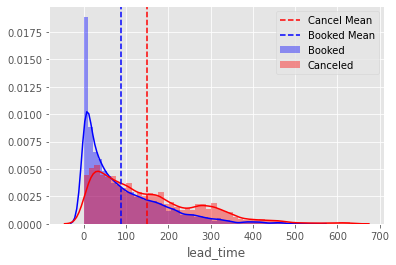

In [50]:
# Comparing distribuions between Bookings and Cancellations
sns.distplot(leadtime_booked['lead_time'], color='blue', label='Booked')
sns.distplot(leadtime_cancl['lead_time'], color='red', label='Canceled')
plt.axvline(np.mean(leadtime_cancl['lead_time']), color='red', linestyle = 'dashed', label='Cancel Mean')
plt.axvline(np.mean(leadtime_booked['lead_time']), color='blue', linestyle = 'dashed', label='Booked Mean')

plt.legend()
plt.show()

In [51]:
# Statistics for 'booked' lead time
leadtime_booked['lead_time'].describe()

count    62733.000000
mean        87.817162
std         91.600142
min          0.000000
25%         15.000000
50%         57.000000
75%        135.000000
max        542.000000
Name: lead_time, dtype: float64

In [52]:
# Statistics for 'canceled' lead time
leadtime_cancl['lead_time'].describe()

count    40161.000000
mean       149.108613
std        119.627904
min          0.000000
25%         52.000000
50%        118.000000
75%        220.000000
max        629.000000
Name: lead_time, dtype: float64

In [53]:
# Percentage Difference
(np.mean(leadtime_cancl['lead_time'])/np.mean(leadtime_booked['lead_time']) -1)*100

69.7943887961897

#### Prepare Data for Analysis | Observations

- For 'all' reservations, the mean lead time for canceled reservations is __69.7%__ greater than booked mean lead time.
- The data distribution is similar, however, the data is right-skewed = __non-normal distribution__.
    - Based on intial analysis, is appears that lead time effects cancellations
      
      __NOTE:__ We will confirm this initial observation by running a statistical test.


### Check Assumptions

#### Check Sample Size(s)

In [54]:
# Size of samples
print(f"Sample Sizes: {len(leadtime_booked), len(leadtime_cancl)}")

Sample Sizes: (62733, 40161)


__Test for Normality__

(If) Data Is Gaussian (normal distribution): Use Parametric Statistical Methods.

(Else:) Use Nonparametric Statistical Methods.

#### Visual Normality Checks

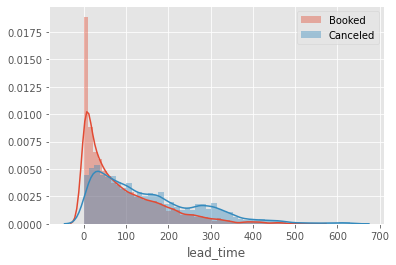

In [55]:
# Comapring distribuions between Bookings and Cancelations > 180 days
sns.distplot(leadtime_booked['lead_time'], label='Booked')
sns.distplot(leadtime_cancl['lead_time'], label='Canceled')

plt.legend()
plt.show()

> __Shown:__ 
- The data distribution is similar, however, the data is right-skewed - __not a normal distribution__.

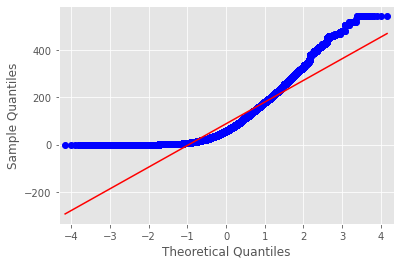

In [56]:
# Normality Check - Booked?
# Visual Normality Tests: Using Q-Q Plot (Quantile-Quantile Plot)
sm.graphics.qqplot(leadtime_booked['lead_time'], line='s');

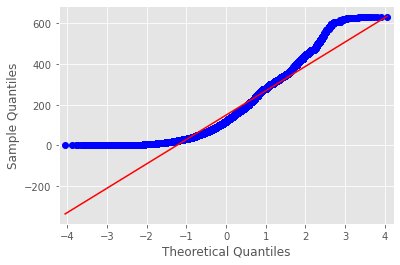

In [57]:
# Normality Check - Canceled?
# Visual Normality Tests: Using Q-Q Plot (Quantile-Quantile Plot)
sm.graphics.qqplot(leadtime_cancl['lead_time'], line='s');

- Q-Q plots show a __non-normal__ distributions as the data points extend away from the red line.

#### Statistical Normality Checks

> In the SciPy implementation of these tests, you can interpret the p value as follows:
- p <= alpha: reject H0, not normal.
- p > alpha: fail to reject H0, normal.

In [58]:
# Normality Check?
# Statistical Normality Tests: Using Shapiro-Wilk Test 
shapiro_test(leadtime_booked['lead_time'],leadtime_cancl['lead_time'])

Statistical Normality Tests: Using Shapiro-Wilk Test
_____
Statistic: 0.8479, P-value: 0.0,  Rounded P-value: 0.0
Test Conclusion: __Reject H0__          Sample does NOT look Gaussian (non-normal distribution)

Statistic: 0.9127, P-value: 0.0,  Rounded P-value: 0.0
Test Conclusion: __Reject H0__          Sample does NOT look Gaussian (non-normal distribution)



/opt/conda/lib/python3.7/site-packages/scipy/stats/morestats.py:1676: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


In [59]:
# Normality Check?
# Statistical Normality Tests: Using KS Test

ks_test(leadtime_booked['lead_time'], "norm")
ks_test(leadtime_cancl['lead_time'], "norm")

Statistical Normality Tests: Using K-S Test
_____
Statistic: 0.9024, P-value: 0.0,  Rounded P-value: 0.0
Test Conclusion: __Reject H0__          Sample distribution is NOT identical to a normal distribution

Statistical Normality Tests: Using K-S Test
_____
Statistic: 0.9849, P-value: 0.0,  Rounded P-value: 0.0
Test Conclusion: __Reject H0__          Sample distribution is NOT identical to a normal distribution



In [60]:
# Normality Check?
# Statistical Normality Tests: Using Anderson-Darling Test
from scipy.stats import anderson

result = anderson(leadtime_cancl['lead_time'])
print('Statistic: %.3f' % result.statistic)
p = 0
for i in range(len(result.critical_values)):
    sl, cv = result.significance_level[i], result.critical_values[i]
    if result.statistic < result.critical_values[i]:
        print('%.3f: %.3f, data looks normal ( __Fail to Reject H0__ )' % (sl, cv))
    else:
        print('%.3f: %.3f, data does not look normal ( __Reject H0__ )' % (sl, cv))

Statistic: 957.986
15.000: 0.576, data does not look normal ( __Reject H0__ )
10.000: 0.656, data does not look normal ( __Reject H0__ )
5.000: 0.787, data does not look normal ( __Reject H0__ )
2.500: 0.918, data does not look normal ( __Reject H0__ )
1.000: 1.092, data does not look normal ( __Reject H0__ )


In [61]:
# Normality Check?
# Statistical Normality Tests: Using Anderson-Darling Test
anderson_test(leadtime_booked['lead_time'],leadtime_cancl['lead_time'])

Statistical Normality Tests: Using Anderson-Darling Test
_____

Statistic: 2756.699
15.000: 0.576 __Reject H0__   Data does NOT look normal
10.000: 0.656 __Reject H0__   Data does NOT look normal
5.000: 0.787 __Reject H0__   Data does NOT look normal
2.500: 0.918 __Reject H0__   Data does NOT look normal
1.000: 1.092 __Reject H0__   Data does NOT look normal

Statistic: 957.986
15.000: 0.576 __Reject H0__   Data does NOT look normal
10.000: 0.656 __Reject H0__   Data does NOT look normal
5.000: 0.787 __Reject H0__   Data does NOT look normal
2.500: 0.918 __Reject H0__   Data does NOT look normal
1.000: 1.092 __Reject H0__   Data does NOT look normal


In [62]:
# Normality Check?
# Statistical Normality Tests: Using D’Agostino’s K^2 Test

from scipy.stats import normaltest

stat, p = normaltest(leadtime_cancl['lead_time'])
print('Statistics=%.3f, p=%.3f' % (stat, p))
# interpret
if p > alpha:
    print(f"p-value is {np.round((p), 4)}, __Fail to Reject H0__  Sample looks Gaussian (normal distribution)")
else:
    print(f"p-value is {np.round((p), 4)}, __Reject H0__  Sample does NOT look Gaussian (non-normal distribution)")

Statistics=5370.271, p=0.000
p-value is 0.0, __Reject H0__  Sample does NOT look Gaussian (non-normal distribution)


#### Observation: Statistical Normality Checks
- All tests __Reject H0__ which indicates that the data does __not__ look normal.  Therefore, samples do __not__ follow a Gaussian distribution.

#### Test for Variance
- The variance criterion holds true when p > a (where a is the probability threshold usually set to 0.05)

In [63]:
# Variance Check?
# Statistical Variance Tests: Using Levene Variance Test 
levene_test(leadtime_booked['lead_time'], leadtime_cancl['lead_time'])

Statistic: 3126.1782, P-value: 0.0,  Rounded P-value: 0.0
Test Conclusion: __Reject H0__     Variances are NOT equal



#### Observations | Check Assumptions:
- Plotting sample datasets appear to be right-skewed, suggesting data has a non-normal distribution.
- Performing several statistical tests for normality, p < 0.05 failing to conform to the normality criterion.
- Performing statistical test for variance, p < 0.05 failing to conform to the variance criterion.
- QQ plot distribution does not conform to the line, suggesting a non-normal distribution.

### Perform Statistic Test

__Which Statistic Test to Run?__
- One of the assumptions of the two sample t-test is that both samples are normally distributed. I can however, thanks to the central limit theorem, bypass this assumption given that both sample sizes are relatively large. The central limit theorem states that given a sufficiently large sample size from a population (usually more than 30) with a finite level of variance, the mean of all samples from the same population will be approximately equal to the mean of the population.

- Another assumption is that the variances. of the two groups you are measuring are equal in the population. To test this assumption i will use the Levene test, which its null hypothesis is that all input samples are from populations with equal variances.

####  Welch's t-test

> Welch's t-test, or unequal variances t-test, is a two-sample location test which is used to test the hypothesis that two populations have equal means.

- Normality & Variance criteria: __Both False__
- Based on above assumptions and observations, we will perform the following:

    - Parametric t-test: __ttest_ind() method by passing the argument equal_var = False__ (Welch's Test)
    - NOTE: It might be the case that your sample data is large enough to apply parametric t-test although the normality criterion is violated.


__Two-Sample t-test__

In [64]:
# Calculate t-statistic for samples, using Two-Sample T-test (independent)
# In case of unequal variances a better option is to call the ttest_ind() method by passing the argument equal_var = False

stat, p = stats.ttest_ind(leadtime_booked['lead_time'], leadtime_cancl['lead_time'], equal_var = False)
print(f"Statistic for sample is {round(stat, 4)} and the p-value is {p}: Rounded the p-value is {np.round((p), 4)}")

if p <= alpha:
    print(f"p-value is {np.round((p), 4)},  Reject the Null hypothesis")
else:
    print(f"p-value is {np.round((p), 4)},  Fail to reject the Null hypothesis")

Statistic for sample is -87.5514 and the p-value is 0.0: Rounded the p-value is 0.0
p-value is 0.0,  Reject the Null hypothesis


__Welch's t-test__

In [66]:
# Calculate statistic for samples, using Welch's T-test which is maintained in the flatirons.py file
p = p_value_welch_ttest(leadtime_booked['lead_time'], leadtime_cancl['lead_time'], two_sided=True)
print(f"The p-value is {p}: Rounded the p-value is {np.round((p), 4)}")

if p <= alpha:
    print(f"p-value is {np.round((p), 4)} - Reject the Null hypothesis")
else:
    print(f"p-value is {np.round((p), 4)} - Fail to reject the Null hypothesis")

The p-value is 0.0: Rounded the p-value is 0.0
p-value is 0.0 - Reject the Null hypothesis


> __Why, Welch's t-test? ....__
- URL: https://www.statisticshowto.com/welchs-test-for-unequal-variances/
- With a significance level of 5% (alpha), I reject the null hypothesis and accept that the samples are not from populations from equal variances. Fortunately, there is a variation of the two sample t-test when samples do not conform to the equal variance assumption. It’s called Welch’s t-test, and it is more reliable when the two samples have unequal variances and/or unequal sample sizes. Since the samples have unequal variances and unequal sample sizes, this is the test I chose to perform hypothesis testing.


#### Observations | Perform Statistic Test :
- Since p-value is 0.0 < a (0.05) we say that the null hypothesis is rejected and suggest an alternative: "that booking in advance does have a statistical significant effect on the number of cancellations.

### Perform Effect Size (Cohen's d) Test

> Cohen'd Test is one of the most common ways to measure effect size. An effect size is how large an effect of something is. 

In [67]:
# Calculate effect size for samples, using Cohen's (D) used to indicate the standardised difference between two means.
cohens_d_results = cohens_d(leadtime_booked['lead_time'], leadtime_cancl['lead_time'])
print(f"The effect size (d) is {cohens_d_results}: Rounded (d) is {np.round((cohens_d_results), 4)}")

The effect size (d) is -0.5924896149544316: Rounded (d) is -0.5925


#### Perform Effect Size | Observation:
-  Cohen's D, how to interpret results:

    - d=0.2 be considered a 'small' effect size

    - d=0.5 represents a 'medium' effect size

    - d=0.8 a 'large' effect size.

> __0.5925__, is a __medium effect size__ according to chart above.

In [68]:
# Sample size
print(f"Sample Sizes: {len(leadtime_booked['lead_time']), len(leadtime_cancl['lead_time'])}")

Sample Sizes: (62733, 40161)


In [69]:
#Calculate sample size required
from statsmodels.stats.power import TTestIndPower, TTestPower
power_analysis = TTestIndPower()
power_analysis.solve_power(effect_size=-0.5925, alpha=.05, power=.8)

45.696185689563

In [70]:
#Calculate minimum effect size to satisfy desired alpha and power as well as respect sample size limitations
power_analysis.solve_power(nobs1=45.6961, alpha=.05, power=.8)

0.5925002822413227

### __Conclusions: 1- Data Analysis__
- __p-value:__ Rounded the p-value is 0.0
- __effect size:__ d=__0.5925__, is a __medium effect size__
- __Observations:__ Since p-value is 0.0 < a (0.05) we say that the null hypothesis is rejected and suggest an alternative: "that lead time has a statistical significant effect on cancellations." Since the mean of the cancellation sample is bigger than the booked sample the conclusion is that booking far in advance increases the probability of cancellation.

## __2- Data Analysis - Lead time > 180 days__

### Prepare Data for Analysis

In [71]:
# Rows of reservations booked > 180 days
leadtime_more_180_booked = df[(df['lead_time'] >= 180) &  (df['is_canceled'] == 0)]
leadtime_more_180_booked[:10]

,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,meal,country,market_segment,distribution_channel,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,reserved_room_type,assigned_room_type,booking_changes,deposit_type,agent,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,reservation_status,reservation_status_date,leadTime_catg
71,Resort Hotel,0,364,2015,July,27,3,3,7,2,0.0,0,BB,GBR,Offline TA/TO,TA/TO,0,0,0,A,A,0,No Deposit,40.0,0,Contract,55.68,0,0,Check-Out,201507,"(300, 365]"
74,Resort Hotel,0,324,2015,July,27,3,4,10,2,0.0,0,HB,GBR,Offline TA/TO,TA/TO,0,0,0,E,E,0,No Deposit,40.0,0,Contract,134.73,0,0,Check-Out,201507,"(300, 365]"
167,Resort Hotel,0,258,2015,July,28,6,2,5,2,0.0,0,BB,GBR,Offline TA/TO,TA/TO,0,0,0,A,A,0,No Deposit,2.0,0,Contract,47.25,0,0,Check-Out,201507,"(180, 270]"
203,Resort Hotel,0,394,2015,July,28,8,2,5,2,0.0,0,HB,GBR,Offline TA/TO,TA/TO,0,0,0,D,D,0,No Deposit,40.0,0,Contract,89.68,0,0,Check-Out,201507,"(365, 765]"
222,Resort Hotel,0,366,2015,July,28,9,2,5,2,0.0,0,HB,GBR,Offline TA/TO,TA/TO,0,0,0,E,E,0,No Deposit,40.0,0,Contract,134.73,0,0,Check-Out,201507,"(365, 765]"
223,Resort Hotel,0,249,2015,July,28,9,2,5,2,0.0,0,HB,PRT,Online TA,TA/TO,0,0,0,A,A,0,No Deposit,240.0,0,Transient,112.00,0,1,Check-Out,201507,"(180, 270]"
257,Resort Hotel,0,304,2015,July,28,11,2,4,2,0.0,1,BB,PRT,Direct,TA/TO,0,0,0,A,A,1,No Deposit,240.0,0,Transient,90.67,0,1,Check-Out,201507,"(300, 365]"
362,Resort Hotel,0,317,2015,July,29,14,1,5,2,2.0,0,HB,PRT,Direct,TA/TO,0,0,0,H,G,1,No Deposit,240.0,0,Transient,230.67,1,2,Check-Out,201507,"(300, 365]"
457,Resort Hotel,0,315,2015,July,29,17,1,2,2,0.0,0,BB,IRL,Offline TA/TO,TA/TO,0,0,0,A,D,0,No Deposit,171.0,0,Transient,96.30,0,0,Check-Out,201507,"(300, 365]"
757,Resort Hotel,0,286,2015,July,31,31,2,2,1,0.0,0,BB,IRL,Direct,Direct,0,0,0,A,A,0,No Deposit,2.0,0,Transient,57.60,0,0,Check-Out,201508,"(270, 300]"


In [72]:
# Rows of reservations canceled > 180 days
leadtime_more_180_cancl = df[(df['lead_time'] >= 180) &  (df['is_canceled'] == 1)]
leadtime_more_180_cancl[:10]

,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,meal,country,market_segment,distribution_channel,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,reserved_room_type,assigned_room_type,booking_changes,deposit_type,agent,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,reservation_status,reservation_status_date,leadTime_catg
70,Resort Hotel,1,368,2015,July,27,3,3,7,2,0.0,0,BB,PRT,Offline TA/TO,TA/TO,0,0,0,A,A,0,No Deposit,40.0,0,Contract,55.68,0,0,Canceled,201505,"(365, 765]"
189,Resort Hotel,1,292,2015,July,28,7,2,5,2,0.0,0,BB,PRT,Offline TA/TO,TA/TO,0,0,0,A,A,0,No Deposit,2.0,0,Contract,47.25,0,0,Canceled,201503,"(270, 300]"
201,Resort Hotel,1,280,2015,July,28,8,2,5,2,1.0,0,HB,PRT,Offline TA/TO,TA/TO,0,0,0,D,D,0,No Deposit,40.0,0,Contract,112.00,0,1,Canceled,201504,"(270, 300]"
336,Resort Hotel,1,321,2015,July,29,13,1,4,2,0.0,0,HB,PRT,Direct,TA/TO,0,0,0,A,A,0,No Deposit,240.0,0,Transient,132.80,0,1,Canceled,201503,"(300, 365]"
600,Resort Hotel,1,312,2015,July,30,24,4,10,3,0.0,0,BB,PRT,Offline TA/TO,TA/TO,0,0,0,A,A,0,No Deposit,40.0,0,Contract,121.98,0,1,Canceled,201507,"(300, 365]"
637,Resort Hotel,1,299,2015,July,30,25,2,5,2,1.0,0,BB,PRT,Online TA,TA/TO,0,0,0,A,A,0,No Deposit,240.0,0,Transient,149.00,0,1,Canceled,201503,"(270, 300]"
681,Resort Hotel,1,298,2015,July,31,27,1,5,3,0.0,0,HB,PRT,Offline TA/TO,TA/TO,0,0,0,A,A,0,No Deposit,175.0,0,Transient,183.45,0,1,Canceled,201503,"(270, 300]"
793,Resort Hotel,1,327,2015,August,32,2,4,10,2,0.0,0,BB,PRT,Offline TA/TO,TA/TO,0,0,0,D,D,0,No Deposit,40.0,0,Contract,104.55,0,0,Canceled,201504,"(300, 365]"
1296,Resort Hotel,1,346,2015,August,36,30,4,8,2,0.0,0,BB,PRT,Offline TA/TO,TA/TO,0,0,0,A,A,0,No Deposit,171.0,0,Transient,96.30,0,0,Canceled,201508,"(300, 365]"
1370,Resort Hotel,1,297,2015,September,36,3,1,3,2,0.0,0,BB,PRT,Direct,TA/TO,0,0,0,A,A,0,No Deposit,240.0,0,Transient,0.00,0,0,Canceled,201411,"(270, 300]"


In [73]:
# View Statistics for booked > 180 days
leadtime_more_180_booked.describe(include='all')

,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,meal,country,market_segment,distribution_channel,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,reserved_room_type,assigned_room_type,booking_changes,deposit_type,agent,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,reservation_status,reservation_status_date,leadTime_catg
count,9861,9861.0,9861.000000,9861.000000,9861,9861.000000,9861.000000,9861.000000,9861.000000,9861.000000,9861.000000,9861.000000,9861,9861,9861,9861,9861.000000,9861.000000,9861.000000,9861,9861,9861.000000,9861,9861.000000,9861.000000,9861,9861.000000,9861.000000,9861.000000,9861,9861,9861
unique,2,NaN,NaN,NaN,12,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5,79,6,3,NaN,NaN,NaN,8,10,NaN,3,NaN,NaN,4,NaN,NaN,NaN,1,27,5
top,City Hotel,NaN,NaN,NaN,July,NaN,NaN,NaN,NaN,NaN,NaN,NaN,BB,GBR,Offline TA/TO,TA/TO,NaN,NaN,NaN,A,A,NaN,No Deposit,NaN,NaN,Transient-Party,NaN,NaN,NaN,Check-Out,201707,"(180, 270]"
freq,6033,NaN,NaN,NaN,1736,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6353,2227,3919,9221,NaN,NaN,NaN,7296,6342,NaN,9840,NaN,NaN,4733,NaN,NaN,NaN,9861,954,6432
mean,NaN,0.0,257.805902,2016.292972,NaN,29.923740,16.133658,1.222290,3.273907,1.896258,0.092688,0.007809,NaN,NaN,NaN,NaN,0.004056,0.000101,0.010547,NaN,NaN,0.354224,NaN,98.503701,7.054964,NaN,98.638944,0.048068,0.764527,NaN,NaN,NaN
std,NaN,0.0,71.039042,0.647244,NaN,9.258682,8.768998,1.136645,2.291823,0.439536,0.374556,0.089169,NaN,NaN,NaN,NaN,0.063564,0.010070,0.122061,NaN,NaN,0.802487,NaN,118.352002,35.495033,NaN,37.795373,0.217214,0.855316,NaN,NaN,NaN
min,NaN,0.0,180.000000,2015.000000,NaN,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,NaN,NaN,NaN,NaN,0.000000,0.000000,0.000000,NaN,NaN,0.000000,NaN,1.000000,0.000000,NaN,-6.380000,0.000000,0.000000,NaN,NaN,NaN
25%,NaN,0.0,204.000000,2016.000000,NaN,23.000000,9.000000,0.000000,2.000000,2.000000,0.000000,0.000000,NaN,NaN,NaN,NaN,0.000000,0.000000,0.000000,NaN,NaN,0.000000,NaN,9.000000,0.000000,NaN,74.250000,0.000000,0.000000,NaN,NaN,NaN
50%,NaN,0.0,237.000000,2016.000000,NaN,30.000000,17.000000,1.000000,3.000000,2.000000,0.000000,0.000000,NaN,NaN,NaN,NaN,0.000000,0.000000,0.000000,NaN,NaN,0.000000,NaN,21.000000,0.000000,NaN,95.400000,0.000000,1.000000,NaN,NaN,NaN
75%,NaN,0.0,292.000000,2017.000000,NaN,37.000000,24.000000,2.000000,5.000000,2.000000,0.000000,0.000000,NaN,NaN,NaN,NaN,0.000000,0.000000,0.000000,NaN,NaN,0.000000,NaN,240.000000,0.000000,NaN,115.000000,0.000000,1.000000,NaN,NaN,NaN


In [74]:
# View Statistics for canceled > 180 days
leadtime_more_180_cancl.describe(include='all')

,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,meal,country,market_segment,distribution_channel,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,reserved_room_type,assigned_room_type,booking_changes,deposit_type,agent,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,reservation_status,reservation_status_date,leadTime_catg
count,13383,13383.0,13383.000000,13383.000000,13383,13383.000000,13383.000000,13383.000000,13383.000000,13383.000000,13383.000000,13383.000000,13383,13383,13383,13383,13383.000000,13383.000000,13383.000000,13383,13383,13383.000000,13383,13383.000000,13383.000000,13383,13383.000000,13383.0,13383.000000,13383,13383,13383
unique,2,NaN,NaN,NaN,12,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5,82,5,4,NaN,NaN,NaN,8,9,NaN,3,NaN,NaN,4,NaN,NaN,NaN,2,34,5
top,City Hotel,NaN,NaN,NaN,September,NaN,NaN,NaN,NaN,NaN,NaN,NaN,BB,PRT,Groups,TA/TO,NaN,NaN,NaN,A,A,NaN,Non Refund,NaN,NaN,Transient,NaN,NaN,NaN,Canceled,201510,"(180, 270]"
freq,10500,NaN,NaN,NaN,2049,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10702,10026,5802,13092,NaN,NaN,NaN,11536,11438,NaN,6875,NaN,NaN,9928,NaN,NaN,NaN,13306,1697,6024
mean,NaN,1.0,290.667264,2016.060525,NaN,30.816558,15.275349,0.898603,2.633939,1.958455,0.069416,0.002466,NaN,NaN,NaN,NaN,0.015990,0.423149,0.000523,NaN,NaN,0.087051,NaN,63.518942,7.813495,NaN,90.403085,0.0,0.242995,NaN,NaN,NaN
std,NaN,0.0,87.852588,0.733253,NaN,10.760086,8.730297,1.025144,1.883461,0.570071,0.329231,0.051082,NaN,NaN,NaN,NaN,0.125443,1.972852,0.025928,NaN,NaN,0.451635,NaN,98.250463,35.608279,NaN,37.643501,0.0,0.587812,NaN,NaN,NaN
min,NaN,1.0,180.000000,2015.000000,NaN,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,NaN,NaN,NaN,NaN,0.000000,0.000000,0.000000,NaN,NaN,0.000000,NaN,1.000000,0.000000,NaN,0.000000,0.0,0.000000,NaN,NaN,NaN
25%,NaN,1.0,220.000000,2016.000000,NaN,23.000000,8.000000,0.000000,2.000000,2.000000,0.000000,0.000000,NaN,NaN,NaN,NaN,0.000000,0.000000,0.000000,NaN,NaN,0.000000,NaN,1.000000,0.000000,NaN,62.000000,0.0,0.000000,NaN,NaN,NaN
50%,NaN,1.0,277.000000,2016.000000,NaN,32.000000,16.000000,1.000000,2.000000,2.000000,0.000000,0.000000,NaN,NaN,NaN,NaN,0.000000,0.000000,0.000000,NaN,NaN,0.000000,NaN,9.000000,0.000000,NaN,85.000000,0.0,0.000000,NaN,NaN,NaN
75%,NaN,1.0,332.000000,2017.000000,NaN,39.000000,22.000000,2.000000,3.000000,2.000000,0.000000,0.000000,NaN,NaN,NaN,NaN,0.000000,1.000000,0.000000,NaN,NaN,0.000000,NaN,83.000000,0.000000,NaN,109.000000,0.0,0.000000,NaN,NaN,NaN


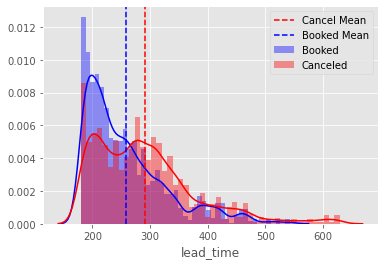

In [75]:
# Comapring distribuions between Bookings and Cancelations > 180 days
sns.distplot(leadtime_more_180_booked['lead_time'], color='blue', label='Booked')
sns.distplot(leadtime_more_180_cancl['lead_time'], color='red', label='Canceled')
plt.axvline(np.mean(leadtime_more_180_cancl['lead_time']), color='red', linestyle = 'dashed', label='Cancel Mean')
plt.axvline(np.mean(leadtime_more_180_booked['lead_time']), color='blue', linestyle = 'dashed', label='Booked Mean')

plt.legend()
plt.show()

In [76]:
# Statistics for 'booked' lead time > 180 days
leadtime_more_180_booked['lead_time'].describe()

count    9861.000000
mean      257.805902
std        71.039042
min       180.000000
25%       204.000000
50%       237.000000
75%       292.000000
max       542.000000
Name: lead_time, dtype: float64

In [77]:
# Statistics for 'canceled' lead time > 180 days
leadtime_more_180_cancl['lead_time'].describe()

count    13383.000000
mean       290.667264
std         87.852588
min        180.000000
25%        220.000000
50%        277.000000
75%        332.000000
max        629.000000
Name: lead_time, dtype: float64

In [78]:
# Percentage Difference
(np.mean(leadtime_more_180_cancl['lead_time'])/np.mean(leadtime_more_180_booked['lead_time']) -1)*100

12.746551627333291

#### Prepare Data for Analysis | Observations

- For reservations more than 180 days, the mean lead time for canceled reservations is __12.7%__ greater than booked mean lead time.
- The data distribution is similar, however, the data is right-skewed = __non-normal distribution__.
    - Based on intial analysis, is appears that mean lead time for cancellatons are more.
      
      __NOTE:__ We will confirm this initial observation by running a statistical test.


### Check Assumptions

#### Check Sample Size(s)

In [79]:
# Sample size?
print(f"Sample Sizes: {len(leadtime_more_180_booked), len(leadtime_more_180_cancl)}")

Sample Sizes: (9861, 13383)


#### Test for Normality

#### Visual Normality Checks

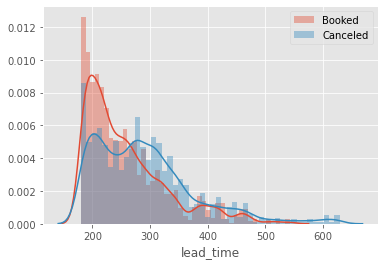

In [80]:
# Comapring distribuions between Bookings and Cancelations > 180 days
sns.distplot(leadtime_more_180_booked['lead_time'], label='Booked')
sns.distplot(leadtime_more_180_cancl['lead_time'], label='Canceled')

plt.legend()
plt.show()

> Data is right-skewed.

- The data distribution is similar, however, the data is right-skewed = __non-normal distribution__.

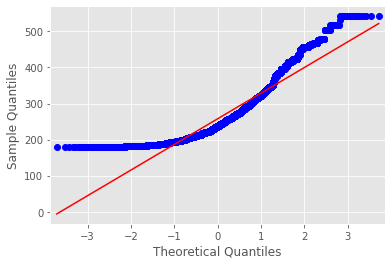

In [81]:
# Normality Check - Booked?
# Visual Normality Tests: Using Q-Q Plot (Quantile-Quantile Plot)
sm.graphics.qqplot(leadtime_more_180_booked['lead_time'], line='s');

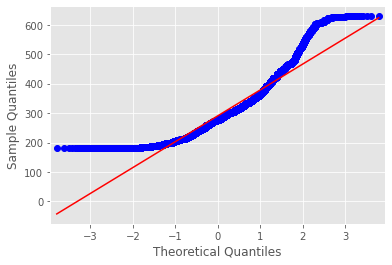

In [82]:
# Normality Check - Canceled?
# Visual Normality Tests: Using Q-Q Plot (Quantile-Quantile Plot)
sm.graphics.qqplot(leadtime_more_180_cancl['lead_time'], line='s');

- Q-Q plots show a __non-normal__ distributions as the data points extend away from the red line.

#### Statistical Normality Checks

In [84]:
# Normality Check?
# Statistical Normality Tests: Using Shapiro-Wilk Test 
shapiro_test(leadtime_more_180_booked['lead_time'],leadtime_more_180_cancl['lead_time'])

Statistical Normality Tests: Using Shapiro-Wilk Test
_____
Statistic: 0.8705, P-value: 0.0,  Rounded P-value: 0.0
Test Conclusion: __Reject H0__          Sample does NOT look Gaussian (non-normal distribution)

Statistic: 0.906, P-value: 0.0,  Rounded P-value: 0.0
Test Conclusion: __Reject H0__          Sample does NOT look Gaussian (non-normal distribution)



/opt/conda/lib/python3.7/site-packages/scipy/stats/morestats.py:1676: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


In [85]:
# Normality Check?
# Statistical Normality Tests: Using KS Test
ks_test(leadtime_more_180_booked['lead_time'], "norm")
ks_test(leadtime_more_180_cancl['lead_time'], "norm")

Statistical Normality Tests: Using K-S Test
_____
Statistic: 1.0, P-value: 0.0,  Rounded P-value: 0.0
Test Conclusion: __Reject H0__          Sample distribution is NOT identical to a normal distribution

Statistical Normality Tests: Using K-S Test
_____
Statistic: 1.0, P-value: 0.0,  Rounded P-value: 0.0
Test Conclusion: __Reject H0__          Sample distribution is NOT identical to a normal distribution



In [86]:
# Normality Check?
# Statistical Normality Tests: Using Anderson-Darling Test
from scipy.stats import anderson

result = anderson(leadtime_more_180_cancl['lead_time'])
print('Statistic: %.3f' % result.statistic)
p = 0
for i in range(len(result.critical_values)):
    sl, cv = result.significance_level[i], result.critical_values[i]
    if result.statistic < result.critical_values[i]:
        print('%.3f: %.3f, data looks normal ( __Fail to Reject H0__ )' % (sl, cv))
    else:
        print('%.3f: %.3f, data does not look normal ( __Reject H0__ )' % (sl, cv))

Statistic: 266.948
15.000: 0.576, data does not look normal ( __Reject H0__ )
10.000: 0.656, data does not look normal ( __Reject H0__ )
5.000: 0.787, data does not look normal ( __Reject H0__ )
2.500: 0.918, data does not look normal ( __Reject H0__ )
1.000: 1.092, data does not look normal ( __Reject H0__ )


In [88]:
# Normality Check?
# Statistical Normality Tests: Using Anderson-Darling Test
anderson_test(leadtime_more_180_booked['lead_time'],leadtime_more_180_cancl['lead_time'])

Statistical Normality Tests: Using Anderson-Darling Test
_____

Statistic: 363.964
15.000: 0.576 __Reject H0__   Data does NOT look normal
10.000: 0.656 __Reject H0__   Data does NOT look normal
5.000: 0.787 __Reject H0__   Data does NOT look normal
2.500: 0.918 __Reject H0__   Data does NOT look normal
1.000: 1.092 __Reject H0__   Data does NOT look normal

Statistic: 266.948
15.000: 0.576 __Reject H0__   Data does NOT look normal
10.000: 0.656 __Reject H0__   Data does NOT look normal
5.000: 0.787 __Reject H0__   Data does NOT look normal
2.500: 0.918 __Reject H0__   Data does NOT look normal
1.000: 1.092 __Reject H0__   Data does NOT look normal


In [89]:
# Normality Check?
# Statistical Normality Tests: Using D’Agostino’s K^2 Test

from scipy.stats import normaltest

stat, p = normaltest(leadtime_more_180_cancl['lead_time'])
print('Statistics=%.3f, p=%.3f' % (stat, p))
# interpret
if p > alpha:
    print(f"p-value is {np.round((p), 4)}, __Fail to Reject H0__  Sample looks Gaussian (normal distribution)")
else:
    print(f"p-value is {np.round((p), 4)}, __Reject H0__  Sample does NOT look Gaussian (non-normal distribution)")

Statistics=2681.564, p=0.000
p-value is 0.0, __Reject H0__  Sample does NOT look Gaussian (non-normal distribution)


#### Test for Variance
- The variance criterion holds true when p > a (where a is the probability threshold usually set to 0.05)

In [90]:
# Variance Check?
# Statistical Variance Tests: Using Levene Variance Test 
levene_test(leadtime_more_180_booked['lead_time'], leadtime_more_180_cancl['lead_time'])

Statistic: 298.5749, P-value: 1.753607252207785e-66,  Rounded P-value: 0.0
Test Conclusion: __Reject H0__     Variances are NOT equal



#### Observations | Check Assumptions:
- Plotting sample datasets appear to be right-skewed, suggesting data has a non-normal distribution.
- Performing several statistical tests for normality, p < 0.05 __failing__ to conform to the normality criterion, therefore __non-normal distribution__.
- Performing statistical test for variance, p < 0.05 __failing__ to conform to the variance criterion, therefore __variance is unequal__.
- QQ plot distribution does not confirm to the line, suggesting a __non-normal distribution__.

### Perform Statistic Test

- Normality & Variance criteria: __Both False__
- Based on above assumptions and observations, we will perform the following:

    - Parametric t-test: __ttest_ind() method by passing the argument equal_var = False__ (Welch's Test)
    - NOTE: It might be the case that your sample data is large enough to apply parametric t-test although the normality criterion is violated.


__Two Sample t-test__

In [91]:
# Calculate t-statistic for samples, using Two-Sample T-test (independent)
# In case of unequal variances a better option is to call the ttest_ind() method by passing the argument equal_var = False

stat, p = stats.ttest_ind(leadtime_more_180_booked['lead_time'], leadtime_more_180_cancl['lead_time'], equal_var = False)
print(f"Statistic for sample is {round(stat, 4)} and the p-value is {p}: Rounded the p-value is {np.round((p), 4)}")

if p <= alpha:
    print(f"p-value is {np.round((p), 4)},  Reject the Null hypothesis")
else:
    print(f"p-value is {np.round((p), 4)},  Fail to reject the Null hypothesis")

Statistic for sample is -31.4975 and the p-value is 3.09554284823593e-213: Rounded the p-value is 0.0
p-value is 0.0,  Reject the Null hypothesis


__Welch's t-test__

In [92]:
# Calculate statistic for samples, using Welch's T-test which is maintained in the flatirons.py file
p = p_value_welch_ttest(leadtime_more_180_booked['lead_time'], leadtime_more_180_cancl['lead_time'], two_sided=True)
print(f"The p-value is {p}: Rounded the p-value is {np.round((p), 4)}")

if p <= alpha:
    print(f"p-value is {np.round((p), 4)} - Reject the Null hypothesis")
else:
    print(f"p-value is {np.round((p), 4)} - Fail to reject the Null hypothesis")

The p-value is 0.0: Rounded the p-value is 0.0
p-value is 0.0 - Reject the Null hypothesis


#### Observations | Perform Statistic Test :
- Since p < a (0.05) we say that the null hypothesis is rejected and suggest an alternative: "that booking 180 days in advance does have a statistical significant effect on the number of cancellations.

### Perform Effect Size (Cohen's d) Test

> __Define Cohen'd Test?__

In [93]:
# Calculate effect size for samples, using Cohen's (D) used to indicate the standardised difference between two means.
cohens_d_results = cohens_d(leadtime_more_180_booked['lead_time'], leadtime_more_180_cancl['lead_time'])
print(f"The effect size (d) is {cohens_d_results}: Rounded (d) is {np.round((cohens_d_results), 4)}")

The effect size (d) is -0.4049647480696398: Rounded (d) is -0.405


#### Perform Effect Size | Observation:
-  Cohen's D, how to interpret results:

    - d=0.2 be considered a 'small' effect size

    - d=0.5 represents a 'medium' effect size

    - d=0.8 a 'large' effect size.

> __0.405__, is a medium effect size according to chart above.

In [94]:
print(f"Sample Sizes: {len(leadtime_more_180_booked['lead_time']), len(leadtime_more_180_cancl['lead_time'])}")

Sample Sizes: (9861, 13383)


In [95]:
#Calculate sample size required
from statsmodels.stats.power import TTestIndPower, TTestPower
power_analysis = TTestIndPower()
power_analysis.solve_power(effect_size=-0.405, alpha=.05, power=.8)

96.6730241948353

In [96]:
#Calculate minimum effect size to satisfy desired alpha and power as well as respect sample size limitations
power_analysis.solve_power(nobs1=96.6730, alpha=.05, power=.8)

0.4050000455015992

### __Conclusions: 2- Data Analysis__
- __p-value:__ Rounded the p-value is 0.0
- __effect size:__ d=__0.405__, is a __medium effect size__
- __Observations:__ Since p-value is 0.0 < a (0.05) we say that the null hypothesis is rejected and suggest an alternative: "that lead time has a statistical significant effect on cancellations."

## __3- Data Analysis - Lead time > 365 days__

### Prepare Data for Analysis

In [97]:
leadtime_more_365_booked = df[(df['lead_time'] >= 365) & (df['is_canceled']==0)]
leadtime_more_365_booked[:10]

,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,meal,country,market_segment,distribution_channel,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,reserved_room_type,assigned_room_type,booking_changes,deposit_type,agent,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,reservation_status,reservation_status_date,leadTime_catg
203,Resort Hotel,0,394,2015,July,28,8,2,5,2,0.0,0,HB,GBR,Offline TA/TO,TA/TO,0,0,0,D,D,0,No Deposit,40.0,0,Contract,89.68,0,0,Check-Out,201507,"(365, 765]"
222,Resort Hotel,0,366,2015,July,28,9,2,5,2,0.0,0,HB,GBR,Offline TA/TO,TA/TO,0,0,0,E,E,0,No Deposit,40.0,0,Contract,134.73,0,0,Check-Out,201507,"(365, 765]"
802,Resort Hotel,0,460,2015,August,32,3,2,5,1,0.0,0,HB,GBR,Offline TA/TO,TA/TO,0,0,0,E,E,0,No Deposit,40.0,0,Contract,77.54,0,0,Check-Out,201508,"(365, 765]"
1349,Resort Hotel,0,381,2015,September,36,1,4,10,2,0.0,0,BB,GBR,Offline TA/TO,TA/TO,0,0,0,E,E,0,No Deposit,40.0,0,Contract,82.88,0,0,Check-Out,201509,"(365, 765]"
1484,Resort Hotel,0,382,2015,September,37,8,4,10,2,0.0,0,BB,GBR,Offline TA/TO,TA/TO,0,0,0,E,E,0,No Deposit,40.0,0,Contract,76.50,0,0,Check-Out,201509,"(365, 765]"
5797,Resort Hotel,0,424,2016,July,29,11,3,7,2,1.0,0,BB,GBR,Offline TA/TO,TA/TO,0,0,0,E,E,0,No Deposit,40.0,0,Transient,112.63,0,1,Check-Out,201607,"(365, 765]"
6540,Resort Hotel,0,367,2016,August,35,21,4,10,2,0.0,0,BB,GBR,Offline TA/TO,TA/TO,0,0,0,D,D,0,No Deposit,2.0,0,Transient,70.00,0,1,Check-Out,201609,"(365, 765]"
6541,Resort Hotel,0,367,2016,August,35,21,4,10,2,0.0,0,BB,GBR,Offline TA/TO,TA/TO,0,0,0,A,A,0,No Deposit,2.0,0,Contract,57.80,0,1,Check-Out,201609,"(365, 765]"
6618,Resort Hotel,0,373,2016,August,35,26,3,7,2,0.0,0,BB,GBR,Offline TA/TO,TA/TO,0,0,0,E,E,0,No Deposit,40.0,0,Contract,85.30,0,0,Check-Out,201609,"(365, 765]"
6639,Resort Hotel,0,374,2016,August,35,27,4,10,2,0.0,0,BB,GBR,Offline TA/TO,TA/TO,0,0,0,E,E,0,No Deposit,40.0,0,Contract,85.30,0,0,Check-Out,201609,"(365, 765]"


In [98]:
leadtime_more_365_cancl = df[(df['lead_time'] >= 365) & (df['is_canceled']==1)]
leadtime_more_365_cancl[:10]

,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,meal,country,market_segment,distribution_channel,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,reserved_room_type,assigned_room_type,booking_changes,deposit_type,agent,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,reservation_status,reservation_status_date,leadTime_catg
70,Resort Hotel,1,368,2015,July,27,3,3,7,2,0.0,0,BB,PRT,Offline TA/TO,TA/TO,0,0,0,A,A,0,No Deposit,40.0,0,Contract,55.68,0,0,Canceled,201505,"(365, 765]"
2112,Resort Hotel,1,368,2015,October,41,10,2,5,1,0.0,0,BB,PRT,Offline TA/TO,TA/TO,0,0,0,A,A,0,No Deposit,96.0,0,Transient,4.00,0,0,Canceled,201505,"(365, 765]"
4802,Resort Hotel,1,468,2016,May,20,12,0,2,2,0.0,0,HB,PRT,Groups,TA/TO,0,0,0,A,A,0,No Deposit,249.0,0,Transient-Party,67.00,0,0,Canceled,201603,"(365, 765]"
4803,Resort Hotel,1,468,2016,May,20,12,0,2,2,0.0,0,HB,PRT,Groups,TA/TO,0,0,0,A,A,0,No Deposit,249.0,0,Transient-Party,67.00,0,0,Canceled,201603,"(365, 765]"
4805,Resort Hotel,1,468,2016,May,20,12,0,2,2,0.0,0,HB,PRT,Groups,TA/TO,0,0,0,A,A,0,No Deposit,249.0,0,Transient-Party,67.00,0,0,Canceled,201603,"(365, 765]"
4806,Resort Hotel,1,468,2016,May,20,12,0,2,2,0.0,0,HB,PRT,Groups,TA/TO,0,0,0,A,A,0,No Deposit,249.0,0,Transient-Party,67.00,0,0,Canceled,201603,"(365, 765]"
4809,Resort Hotel,1,468,2016,May,20,12,0,2,2,0.0,0,HB,PRT,Groups,TA/TO,0,0,0,A,A,0,No Deposit,249.0,0,Transient-Party,67.00,0,0,Canceled,201603,"(365, 765]"
4810,Resort Hotel,1,468,2016,May,20,12,0,2,2,0.0,0,HB,PRT,Groups,TA/TO,0,0,0,A,A,1,No Deposit,249.0,0,Transient-Party,26.00,0,0,Canceled,201605,"(365, 765]"
4811,Resort Hotel,1,468,2016,May,20,12,0,2,2,0.0,0,HB,PRT,Groups,TA/TO,0,0,0,A,A,0,No Deposit,249.0,0,Transient-Party,67.00,0,0,Canceled,201603,"(365, 765]"
4812,Resort Hotel,1,468,2016,May,20,12,0,2,2,0.0,0,HB,PRT,Groups,TA/TO,0,0,0,A,A,0,No Deposit,249.0,0,Transient-Party,67.00,0,0,Canceled,201603,"(365, 765]"


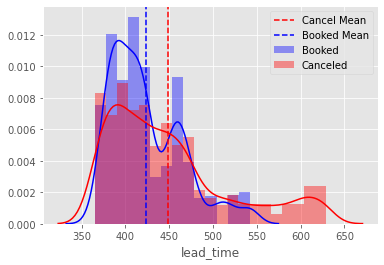

In [99]:
# Comapring distribuions between Bookings and Cancelations > 180 days
sns.distplot(leadtime_more_365_booked['lead_time'], color='blue', label='Booked')
sns.distplot(leadtime_more_365_cancl['lead_time'], color='red', label='Canceled')
plt.axvline(np.mean(leadtime_more_365_cancl['lead_time']), color='red', linestyle = 'dashed', label='Cancel Mean')
plt.axvline(np.mean(leadtime_more_365_booked['lead_time']), color='blue', linestyle = 'dashed', label='Booked Mean')

plt.legend()
plt.show()

In [100]:
leadtime_more_365_booked['lead_time'].describe()

count    950.000000
mean     423.391579
std       40.575579
min      365.000000
25%      394.000000
50%      414.000000
75%      457.000000
max      542.000000
Name: lead_time, dtype: float64

In [101]:
leadtime_more_365_cancl['lead_time'].describe()

count    2103.000000
mean      448.747979
std        70.058703
min       365.000000
25%       393.000000
50%       433.000000
75%       475.000000
max       629.000000
Name: lead_time, dtype: float64

In [102]:
# Percentage Difference
(np.mean(leadtime_more_365_cancl['lead_time'])/np.mean(leadtime_more_365_booked['lead_time']) -1)*100

5.988876820172173

#### Prepare Data for Analysis | Observations

- For reservations more than 365 days, the mean lead time for canceled reservations is greater = __5.9%__
- The data distribution is similar, however, the data is right-skewed = __non-normal distribution__.
    - Based on intial analysis, is appears that lead time for cancellations is more.
      
      __NOTE:__ We will confirm this initial observation by running a statistical test.


### Check Assumptions

#### Visual Normality Check

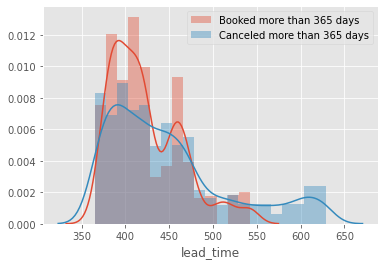

In [103]:
# Normality Check?
sns.distplot(leadtime_more_365_booked['lead_time'], label='Booked more than 365 days' )
sns.distplot(leadtime_more_365_cancl['lead_time'], label='Canceled more than 365 days')
plt.legend()
plt.show()

__Statistical Normality Checks__

In [104]:
# Normality Check?
# Statistical Normality Tests: Using Shapiro-Wilk Test 

# In the SciPy implementation of these tests, you can interpret the p value as follows:
#     p <= alpha: reject H0, not normal.
#     p > alpha: fail to reject H0, normal.

shapiro_test(leadtime_more_365_booked['lead_time'],leadtime_more_365_cancl['lead_time'])

Statistical Normality Tests: Using Shapiro-Wilk Test
_____
Statistic: 0.9074, P-value: 1.4654247784567348e-23,  Rounded P-value: 0.0
Test Conclusion: __Reject H0__          Sample does NOT look Gaussian (non-normal distribution)

Statistic: 0.8833, P-value: 3.7581925740096883e-37,  Rounded P-value: 0.0
Test Conclusion: __Reject H0__          Sample does NOT look Gaussian (non-normal distribution)



In [105]:
# Normality Check?
# Statistical Normality Tests: Using KS Test

ks_test(leadtime_more_365_booked['lead_time'], "norm")
ks_test(leadtime_more_365_cancl['lead_time'], "norm")

Statistical Normality Tests: Using K-S Test
_____
Statistic: 1.0, P-value: 0.0,  Rounded P-value: 0.0
Test Conclusion: __Reject H0__          Sample distribution is NOT identical to a normal distribution

Statistical Normality Tests: Using K-S Test
_____
Statistic: 1.0, P-value: 0.0,  Rounded P-value: 0.0
Test Conclusion: __Reject H0__          Sample distribution is NOT identical to a normal distribution



__Test for Variance__
- The variance criterion holds true when p > a (where a is the probability threshold usually set to 0.05)

In [106]:
# Variance Check?
# Statistical Variance Tests: Using Levene Variance Test 
levene_test(leadtime_more_365_booked['lead_time'], leadtime_more_365_cancl['lead_time'])

Statistic: 169.7108, P-value: 8.560769818598236e-38,  Rounded P-value: 0.0
Test Conclusion: __Reject H0__     Variances are NOT equal



#### Observations | Check Assumptions:
- Plotting sample datasets appear to be right-skewed, suggesting data has a non-normal distribution.
- Performing several statistical tests for normality, p < 0.05 __failing__ to conform to the normality criterion, therefore __non-normal distribution__.
- Performing statistical test for variance, p < 0.05 __failing__ to conform to the variance criterion, therefore __variance is unequal__.
- QQ plot distribution does not confirm to the line, suggesting a __non-normal distribution__.


### Perform Statistic Test

__Welch's t-test__

In [107]:
# Calculate statistic for samples, using Welch's T-test which is maintained in the flatirons.py file
p = p_value_welch_ttest(leadtime_more_365_booked['lead_time'], leadtime_more_365_cancl['lead_time'], two_sided=True)
print(f"The p-value is {p}: Rounded the p-value is {np.round((p), 4)}")

if p <= alpha:
    print(f"p-value is {np.round((p), 4)} - Reject the Null hypothesis")
else:
    print(f"p-value is {np.round((p), 4)} - Fail to reject the Null hypothesis")

The p-value is 0.0: Rounded the p-value is 0.0
p-value is 0.0 - Reject the Null hypothesis


### Perform Effect Size (Cohen's d) Test

In [108]:
# Calculate effect size for samples, using Cohen's (D) used to indicate the standardised difference between two means.
cohens_d_results = cohens_d(leadtime_more_365_booked['lead_time'], leadtime_more_365_cancl['lead_time'])
print(f"The effect size (d) is {cohens_d_results}: Rounded (d) is {np.round((cohens_d_results), 4)}")

NameError: name 'fs' is not defined

__Perform Effect Size | Observation:__
-  Cohen's D, how to interpret results:

    - d=0.2 be considered a 'small' effect size

    - d=0.5 represents a 'medium' effect size

    - d=0.8 a 'large' effect size.

> __0.4064__, is a medium effect size according to chart above. 

In [ ]:
#Calculate sample size required
from statsmodels.stats.power import TTestIndPower, TTestPower
power_analysis = TTestIndPower()
power_analysis.solve_power(effect_size=-0.4064, alpha=.05, power=.8)

### __Conclusions: 3- Data Analysis__
- __p-value:__ Rounded the p-value is 0.0
- __effect size:__ d=__0.4064__, is a __medium effect size__
- __Observations:__ Since p-value is 0.0 < a (0.05) we say that the null hypothesis is rejected and suggest an alternative: "that lead time has a statistical significant effect on cancellations." 

## __Hypothesis Test 1 - Conclusions:__
- __p-value:__ Rounded p-value is __0.0__ for all analysis performed on lead time for all reservations, and reservations made greater than 180 days and 365 days.
- __Observations:__ Since p-value is __0.0__ < a (0.05) we say that the null hypothesis is rejected and suggest an alternative: "that lead time has a statistical significant effect on cancellations." Since the mean of the cancellation sample is bigger than the booked sample the conclusion is that booking far in advance increases the probability of cancellation.

# __Hypothesis Test 2: Which specific Lead Time Categories have an effect on cancellations?__

- Based on __Hypothesis Test 1 - Conclusions__, which indicates that cancellations are effected by lead time, we would like to know which specific lead time categories have the most significant effect. In other words our null hypothesis is that the means of all populations are equal.  Rejecting the null hypothesis would mean that there is a significant difference between at least two of the lead time categories.

- The decision to reject the null hypothesis and accept the alternative hypothesis is based on the significance level of the test (alpha) and the probability of observing the effect given that the null hypothesis is true (p-value). If p < alpha the null hypothesis is ruled out. We typically use a value of alpha = 0.05, which corresponds to 95% confidence.

## State Hypothesis:
- $H_{0}$: The null hypothesis is that lead time categories do __not__ have an effect on cancellations.
  
  $H_{0}: \mu1 = \mu2$ 
  
  
- $H_{1}$: The alternative hypothesis is that lead time categories __do__ have an effect on cancellations.
   
  $H_{1}: \mu1 ≠ \mu2$  
  
  
- __α__:   The significance level, also denoted as alpha or α, is the probability of rejecting the null hypothesis when it is true.

  __α__ = 0.05 or 5%

## Anova Test (One-way)

### Prepare data for analysis

In [ ]:
# Prepare dataset for evaluation
df_cancl = df.loc[df['is_canceled']==1]
df_cancl = df_cancl.dropna()
display(df_cancl.head(), df_cancl.shape)

In [ ]:
# Preview leadTime Categories
df_cancl_grp = df_cancl.groupby(by='leadTime_catg').count().reset_index()
df_cancl_grp

In [ ]:
df_cancl['leadTime_catg'] = df_cancl['leadTime_catg'].astype(str)

### Perform One-way Anova Test

> One-way ANOVA and returns the F and p values from the test. 

In [ ]:
# ANOVA Test: Lead Time Category
formula = 'lead_time ~ C(leadTime_catg)'
lm = ols(formula, df_cancl).fit()
table = sm.stats.anova_lm(lm, typ=2)
table

- As 0.00 < 0.05 we reject the null hypothesis and we conclude that at least one of the means is different from at least one other population mean (i.e. not all leadTime categories perform equally).

## Perform Tukey Analysis

> The thing with one-way ANOVA is that although we now know that there is difference in the lead time categories, we do not know know exactly which category performed best or worst with the cancellations. This is why the analysis of variance is often followed by a post hoc analysis.
- This a common method used as post hoc analysis after one-way ANOVA. This test compares all possible pairs and we can use it to precisely identify difference between two means that's greater than the expected standard error.

In [ ]:
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from statsmodels.stats.multicomp import MultiComparison

mc = MultiComparison(df_cancl['lead_time'], df_cancl['leadTime_catg'])
result = mc.tukeyhsd()
 
print(result)
print(mc.groupsunique)

## __Hypothesis Test 2 | Conclusions:__
- Tukey analysis indicates that from __0-6 days__ lead time has no effect on cancellations; booking __7 days or more__ in advance contributes significantly to reservation cancellations.
- Since p < a (0.05) we say that the null hypothesis is rejected and suggest an alternative: "that booking 7 days or more days in advance does have a statistical significant effect on the number of cancellations." 
- In the ANOVA test, the p-value of our categorical 'Lead Time Catg' variable is ~0.00 as shown in the above table. Since this value is less than our alpha of 0.05, we reject the null hypothesis. 
- In the Tukey test, post-hoc test, the interaction among variables (lead time for cancelled reservations and lead time categories) did show a statistically significant difference as shown in the following:
    - "reject = False": Indicates Bookings made in advance - 0-6 days, __do not__ have an effect on cancellations.
    - "reject = True" : Indicates Bookings made in advance - more than 7 days, __do__ have an effect on cancellations.

In [ ]:
df_cancl['leadTime_catg'].unique()

In [ ]:
# Cancellation Rate for 0-6 Days 
df_cancl_rate_6_days = (df_cancl[((df_cancl['leadTime_catg']=='(0, 6]') | (df_cancl['leadTime_catg']=='(6, 7]'))]['is_canceled'].sum() * 100)/df_cancl['is_canceled'].sum() 
df_cancl_rate_6_days   # 2.5513908710783944

In [ ]:
# Cancellation Rate for more than 7 Days 
df_cancl_rate_7plus_days = (df_cancl[((df_cancl['leadTime_catg']!='(0, 6]') & (df_cancl['leadTime_catg']!='(6, 7]'))]['is_canceled'].sum() * 100)/df_cancl['is_canceled'].sum() 
df_cancl_rate_7plus_days  # 97.4486091289216

# Final Conclusions

- Hypothesis testing is a strong and very important statistical tool that enable us to test conventional knowledge using sample data. Most parametric testing assume normality, but thanks to the central limit theorem, it is possible to bypass this assumption with large enough samples. Moreover, a variation of the two sample t-test called Welch’s t-test enables us to compare two sample means with unequal variances, which are the tests used to perform this study.

__Booking Cancellation Insights__

- Lead time is a feature in the dataset that significantly contributes to canceled reservations.
- Booking a reservation 7 days or more in advance increases the probability for a canceled reservation.   
- Cancellation Percentage: __0-6 days = 2.5 %__   

# Future Work

- I would like to perform the following additional hypothesis tests:

   - •	H1:  Cancellation probability is the highest for rooms booked online (OTA) and the lowest for rooms booked through travel agencies 
   -  •	H2: Country of origin affects the probability of cancellation 
   -  •	H3:  Guests travelling long  distances  are  less  likely  to  cancel  bookings  than  are domestic guests or guests from neighboring countries 
   - •	H4: Cancellation probability is higher during peak seasons 
       - NOTE: Summer Peak Season (June – August) The peak tourist season is from June until the end of August, and during this period there is a buzzing, vibrant atmosphere about the city.
       In the off-season (roughly November–March), expect shorter hours, more lunchtime breaks at sights, and fewer activities — with the big exceptions of Christmas festivities and Entrudo (carnival), which is especially raucous in Lisbon and a few towns in the Algarve.
   - •	H5:  Large groups of  adults  pose  a  higher  cancellation  risk  than  others,  but bookings that include children are less likely to be cancelled


In [ ]:
end = datetime.datetime.now()
elapsed_time = end - start
print(f'Hypothesis Testing Total Execution Time: {elapsed_time}')

# End Study